In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
inspector = inspect(engine)

In [7]:
inspector.get_table_names()

['measurement', 'station']

In [8]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect = True)

In [11]:
# We can view all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [15]:
# find the last date of measurement

session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [16]:
#  find the start date

one_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print (one_year)

2016-08-23


In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

last_year = [Measurement.date, Measurement.prcp]
precip = session.query(*last_year).filter(Measurement.date >= '2016-08-23').all()

In [18]:
precip_df = pd.DataFrame(precip).rename(columns={"date": "Date", "prcp": "Precipitation"}).dropna()
precip_df

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
2223,2017-08-17,0.13
2225,2017-08-19,0.09
2227,2017-08-21,0.56
2228,2017-08-22,0.50


In [19]:
precip_df = precip_df.set_index("Date")
precip_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-17,0.13
2017-08-19,0.09
2017-08-21,0.56


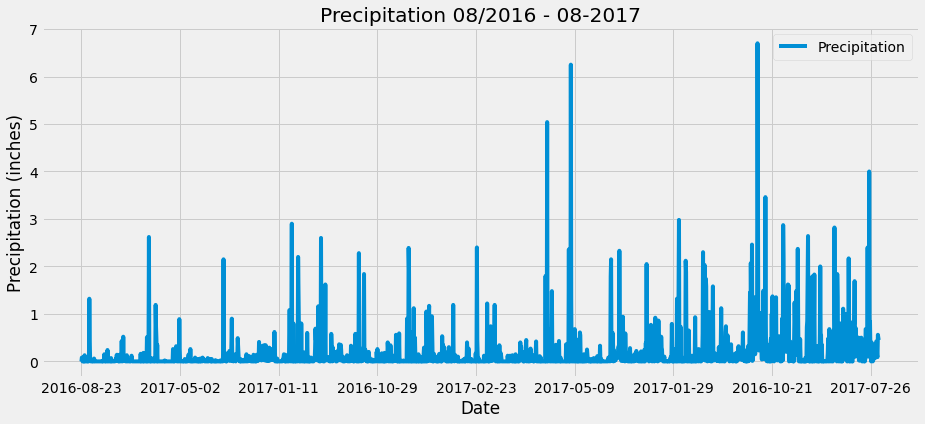

In [20]:
fig, ax = plt.subplots(figsize = (14, 6))
precip_df.plot(ax = ax, x_compat = True)
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (inches)')
ax.set_title("Precipitation 08/2016 - 08-2017")
plt.savefig("precip1.png")
plt.show()

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [22]:
# Design a query to show how many stations are available in this dataset?

stations = session.query(Station.id).distinct().count()
stations

9

In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_station = session.query(Station.station, func.count(Measurement.id)).select_from(Measurement).\
    join(Station, Measurement.station == Station.station).group_by(Station.station).\
    order_by(func.count(Measurement.id).desc()).all()

for result in active_station:
    print(f"Station: {result[0]}\tCount: {result[1]}")

Station: USC00519281	Count: 2772
Station: USC00519397	Count: 2724
Station: USC00513117	Count: 2709
Station: USC00519523	Count: 2669
Station: USC00516128	Count: 2612
Station: USC00514830	Count: 2202
Station: USC00511918	Count: 1979
Station: USC00517948	Count: 1372
Station: USC00518838	Count: 511


In [24]:
most_active_station = active_station[0][0]
most_active_station

'USC00519281'

In [25]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
print(f"Lowest Temperature: {temp[0][0]} F")
print(f"Average Temperature: {round(temp[0][2],2)} F")
print(f"Highest Temperature: {temp[0][1]} F")


Lowest Temperature: 54.0 F
Average Temperature: 71.66 F
Highest Temperature: 85.0 F


In [26]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

top_station = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()
top_station

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-

In [27]:
top_station_df = pd.DataFrame(top_station, columns = ['date', 'temperature'])

top_station_df.set_index('date', inplace = True)
top_station_df

,temperature
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


Text(0.5, -1.340000000000014, 'Temperature')

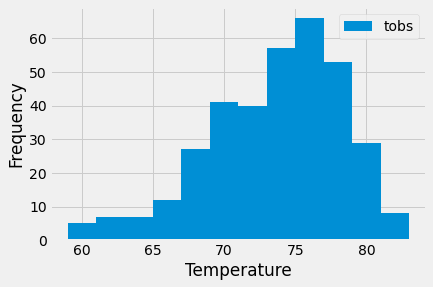

In [28]:
temps = [Measurement.date, Measurement.tobs]

temp_histo = session.query(*temps).filter(Measurement.date >= '2016-08-23').filter(Measurement.station == 'USC00519281' ).all()
temp_histo = pd.DataFrame(temp_histo)
temp_histo.plot.hist(bins=12)

plt.savefig('temp1.png')
plt.xlabel("Temperature")

## Bonus Challenge Assignment

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

temps2 = calc_temps('2017-03-12', '2017-03-19')
print(f"Min Temperature: {temps2[0][0]} F")
print(f"Average Temperature: {round(temps2[0][1],2)} F")
print(f"Max Temperature: {temps2[0][2]} F")

Min Temperature: 65.0 F
Average Temperature: 71.59 F
Max Temperature: 80.0 F


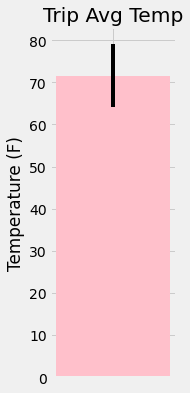

In [31]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temp_plot = temps2[0][2] - temps2[0][0]
avg_temp = temps2[0][1]
fig, ax = plt.subplots(figsize = (2, 6))
ax.bar(1, avg_temp, yerr = temp_plot/2, width = 0.1, color='pink')
ax.set_xticks([1])
ax.set_xticklabels([""])
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temperature (F)')
plt.savefig("temp2.png")
plt.show()

In [32]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude,
                               Station.elevation, func.avg(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2017,3,12)).group_by(Station.station).\
    order_by(func.avg(Measurement.prcp).desc()).all()

In [33]:
total_rainfall_df = pd.DataFrame(total_rainfall, columns = ['Station', 'Name', 'Latitude', 'Longitude', 
                                                              'Elevation', 'Avg. Precipitation (in)'])

total_rainfall_df

,Station,Name,Latitude,Longitude,Elevation,Avg. Precipitation (in)
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.376812
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.194768
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.138310
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.113750
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.111000
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.023937
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.009500


In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [35]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [36]:
dates = ["03-12", "03-13", "03-14", "03-15", "03-16", "03-17", "03-18", "03-19"]

normals = []

for date in dates:
    day = {}
    day['Date'] = f"2018-{date}"
    normal = daily_normals(date)
    day['Min'] = normal[0][0]
    day['Avg'] = round(normal[0][1])
    day['Max'] = normal[0][2]
    normals.append(day)

normals

[{'Date': '2018-03-12', 'Min': 62.0, 'Avg': 70, 'Max': 80.0},
 {'Date': '2018-03-13', 'Min': 56.0, 'Avg': 69, 'Max': 77.0},
 {'Date': '2018-03-14', 'Min': 62.0, 'Avg': 70, 'Max': 77.0},
 {'Date': '2018-03-15', 'Min': 58.0, 'Avg': 69, 'Max': 76.0},
 {'Date': '2018-03-16', 'Min': 60.0, 'Avg': 70, 'Max': 78.0},
 {'Date': '2018-03-17', 'Min': 57.0, 'Avg': 69, 'Max': 75.0},
 {'Date': '2018-03-18', 'Min': 57.0, 'Avg': 68, 'Max': 76.0},
 {'Date': '2018-03-19', 'Min': 60.0, 'Avg': 69, 'Max': 75.0}]

In [37]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_dates = pd.DataFrame(normals)
trip_dates.set_index('Date', inplace = True)
trip_dates

,Min,Avg,Max
Date,,,
2018-03-12,62.0,70,80.0
2018-03-13,56.0,69,77.0
2018-03-14,62.0,70,77.0
2018-03-15,58.0,69,76.0
2018-03-16,60.0,70,78.0
2018-03-17,57.0,69,75.0
2018-03-18,57.0,68,76.0
2018-03-19,60.0,69,75.0


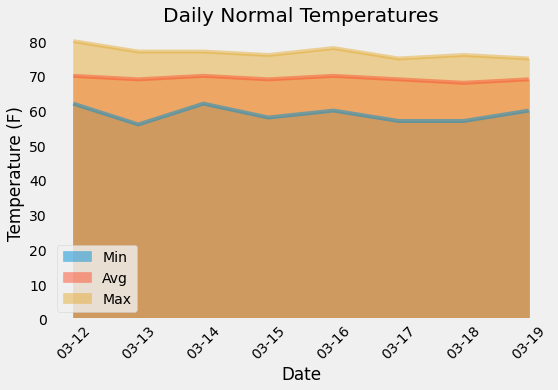

In [38]:
# Plot the daily normals as an area plot with `stacked=False`
fig, ax = plt.subplots(figsize = (8, 5))
trip_dates.plot.area(ax = ax, stacked = False)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (F)')
ax.set_title('Daily Normal Temperatures')
temps3 = [f"2018-{date}" for date in dates]
ax.set_xticks(np.arange(len(temps3)))
ax.set_xticklabels(dates, rotation = 45)
plt.savefig('temp3.png')
plt.grid()
plt.show()